In [51]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Available device: {device}")

Available device: cpu


## Resources
* PyTorch [cheat sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).
* `torch.nn` [documentation](https://pytorch.org/docs/stable/nn.html).
* `torchvision` [documentation](https://pytorch.org/vision/stable/index.html).

## Load MNIST data

In [2]:
def plot_images(
    images: torch.Tensor,
    labels: torch.Tensor,
    num_images: int=9,
) -> None:
  """Visualize images."""
  batch_size = images.size(0)

  # Select images.
  which_imgs = np.random.choice(batch_size, num_images, replace=False)
  imgs = images[which_imgs, :]
  labs = labels[which_imgs]

  # Create plot.
  n = math.floor(math.sqrt(num_images))
  fig, axes = plt.subplots(n, n, figsize=(6, 6))
  for i, ax in enumerate(axes.flat):
    img = imgs[i].numpy().transpose((1, 2, 0)).squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labs[i].item()}")
    ax.axis('off')

  # Display plot.
  plt.tight_layout()
  plt.show()

  return None

In [65]:
%%capture
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define data loaders.
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=1000, shuffle=False)

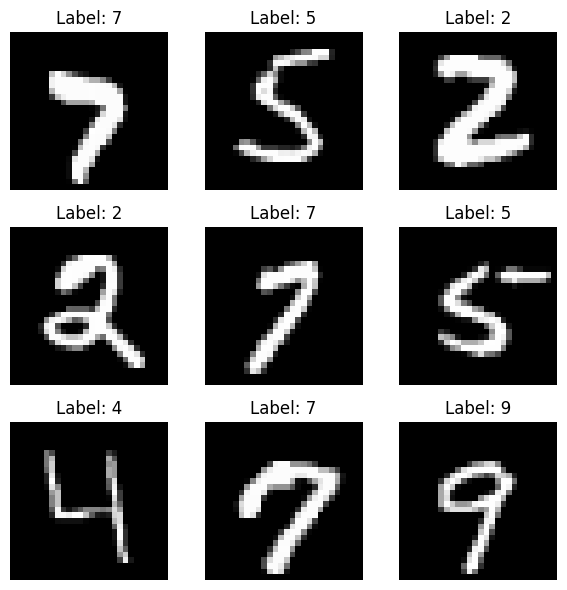

In [4]:
# Inspect a batch.
images, labels = next(iter(train_loader))
plot_images(images, labels)

## Basic model

* Any subclass of `torch.nn.Module` must define a `forward` method.

In [5]:
class SoftmaxRegression(torch.nn.Module):
  """Softmax regression.

  Note the output for the forward pass is on logit scale.

  """

  def __init__(self, input_size: int=28*28, n_classes: int=10):
    super().__init__()
    self.linear = torch.nn.Linear(input_size, n_classes)

  def forward(self, x):
    out = self.linear(x)
    return out

### Train model
* Key steps:
  1. Forward pass
  2. Calculate loss
  3. Zero gradients
  4. Backward pass
  5. Update weights

In [6]:
def fit_model(
    loader,
    lr: float=0.001,
    epochs: int=10,
):

  model = SoftmaxRegression()
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
      for batch_idx, (images, labels) in enumerate(loader):

          # Forward pass.
          flat_images = images.view(-1, 28*28)
          logits = model(flat_images)
          loss = loss_fn(logits, labels)

          # Updated weights.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

  return model

In [7]:
model = fit_model(train_loader)

Epoch [1/10], Loss: 0.1600
Epoch [2/10], Loss: 0.3802
Epoch [3/10], Loss: 0.1754
Epoch [4/10], Loss: 0.3377
Epoch [5/10], Loss: 0.5416
Epoch [6/10], Loss: 0.2574
Epoch [7/10], Loss: 0.2053
Epoch [8/10], Loss: 0.5985
Epoch [9/10], Loss: 0.0553
Epoch [10/10], Loss: 0.7612


### Inspect model parameters

In [19]:
state_dict = model.state_dict()
state_dict.keys()

odict_keys(['linear.weight', 'linear.bias'])

In [23]:
weights = state_dict["linear.weight"]
weights.shape

torch.Size([10, 784])

In [24]:
biases = state_dict["linear.bias"]
biases.shape

torch.Size([10])

### Generate predictions

In [72]:
results = {"y": [], "yhat": [], "probs": []}
with torch.inference_mode():
  for images, labels in test_loader:
      flat_images = images.view(-1, 28*28)
      logits = model(flat_images)

      # Apply softmax to each row.
      probs = F.softmax(logits, dim=1)

      # Check that the sum across is row is 1.0.
      assert torch.allclose(probs.sum(dim=1), torch.ones(probs.shape[0]))

      # Obtain hard classification.
      yhat = probs.argmax(dim=1)

      # Results.
      results["y"].extend(np.array(labels))
      results["yhat"].extend(np.array(yhat))
      results["probs"].append(np.array(probs))


In [76]:
# Data frame of observed and predicted labels.
df_results = pd.DataFrame({
  "y": results["y"],
  "yhat": results["yhat"],
})

In [77]:
# Matrix of predicted probabilities.
probs = np.vstack(results["probs"])

### Evaluate model

* [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [81]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

In [82]:
# One-hot representation of labels.
y_one_hot = label_binarize(df_results["y"], classes=np.arange(10))

In [86]:
# AUROC.
macro_auroc = roc_auc_score(
  y_one_hot,
  probs,
  average='macro',
  multi_class='ovr',
)
print(f"{macro_auroc:0.3f}")

0.994


In [87]:
# AUPRC.
macro_auprc = average_precision_score(
  y_one_hot,
  probs,
  average='macro',
)
print(f"{macro_auprc:0.3f}")

0.968


### Save model

* Saving and loading [tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [90]:
import os

In [94]:
if not os.path.exists("models"):
  os.mkdir("models")

In [95]:
fout = "models/model0.pth"
torch.save(model.state_dict(), fout)

In [97]:
new_model = SoftmaxRegression()
new_model.load_state_dict(torch.load(fout))

<All keys matched successfully>